# **Rule of Thumb 3**: Draw More to Score More

## **Imports and Load Data**

In [1]:
# imports
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# imports for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# load Ends.csv from github
ends_path = 'https://raw.githubusercontent.com/CSAS-Data-Challenge/2026/refs/heads/main/Ends.csv'
stones_path = 'https://raw.githubusercontent.com/CSAS-Data-Challenge/2026/refs/heads/main/Stones.csv'

Ends = pd.read_csv(ends_path)
Stones = pd.read_csv(stones_path)

## **Data Transformations**

In [3]:
# CREATE A DATAFRAME FOR ALL MATCHES THAT HOLDS THE HAMMER SCORE
# Merge the Stones and Ends dataframes
stones_ends = pd.merge(Stones, Ends, on=['CompetitionID', 'SessionID', 'GameID', 'EndID', 'TeamID'])

# Create a MatchID for each unique match
unique_matches = stones_ends[['CompetitionID', 'SessionID', 'GameID']].drop_duplicates().reset_index(drop=True)
unique_matches['MatchID'] = unique_matches.index + 1

# Add the MatchID to the stones_ends dataframe
stones_ends = pd.merge(stones_ends, unique_matches, on=['CompetitionID', 'SessionID', 'GameID'])

# Remove Stones on Non-Powerplay Ends
powerplay_team_stones = stones_ends[stones_ends['PowerPlay'].notna()]
unique_pp_ends = powerplay_team_stones[['MatchID', 'EndID']].drop_duplicates()
# Create New Column for when the Powerplay is used (PP Used)
unique_pp_ends['PP Used'] = True

# Add PP Used to stones_ends dataframe
stones_ends = pd.merge(stones_ends, unique_pp_ends, on=['MatchID', 'EndID'], how='left')
stones_ends['PP Used'] = stones_ends['PP Used'].fillna(False)

# For each match
for match_id in stones_ends['MatchID'].unique():
    # collect all of the match data (stone by stone)
    match_data = stones_ends[stones_ends['MatchID'] == match_id]
    # for each end
    for end_id in match_data['EndID'].unique():
        # retrieve the end data for the given match
        end_data = match_data[match_data['EndID'] == end_id]
        # retrieve the hammer and non-hammer results
        hammer_result = end_data['Result'].iloc[1]
        non_hammer_result = end_data['Result'].iloc[0]
        hammer_score = hammer_result - non_hammer_result
        # add hammer score value where MatchID = match_id and EndID = end_id
        stones_ends.loc[(stones_ends['MatchID'] == match_id) & (stones_ends['EndID'] == end_id), 'HammerScore'] = hammer_score

unique_match_ends = stones_ends[['CompetitionID', 'SessionID', 'GameID', 'EndID', 'HammerScore', 'PP Used']].drop_duplicates()

/tmp/ipython-input-1044521045.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stones_ends['PP Used'] = stones_ends['PP Used'].fillna(False)


In [4]:
# CREATE A DATAFRAME TO STORE JUST POWERPLAY DATA
# merge stones and ends to retrieve result and powerplay condition
stones_ends = pd.merge(Stones, Ends, on=['CompetitionID', 'SessionID', 'GameID', 'EndID', 'TeamID'])
# identify unique matches and add a unique match_id
unique_matches = stones_ends[['CompetitionID', 'SessionID', 'GameID']].drop_duplicates().reset_index(drop=True)
unique_matches['MatchID'] = unique_matches.index + 1
stones_ends = pd.merge(stones_ends, unique_matches, on=['CompetitionID', 'SessionID', 'GameID'])

# only include stones thrown during Power Plays
powerplay_team_stones = stones_ends[stones_ends['PowerPlay'].notna()]
unique_pp_ends = powerplay_team_stones[['MatchID', 'EndID']].drop_duplicates()
unique_pp_ends['PP Used'] = True
stones_ends = pd.merge(stones_ends, unique_pp_ends, on=['MatchID', 'EndID'], how='left')

# Create a separate dataframe for when the Power Play is used
powerplay_stones = stones_ends[stones_ends['PP Used'] == True]

# make a copy of powerplay_stones
powerplay_stones = powerplay_stones.copy()

# mark the hammer if PowerPlay not NaN
powerplay_stones['Hammer'] = powerplay_stones['PowerPlay'].apply(lambda x: 0 if pd.isna(x) else 1)

# Intiaite a column to track Hammer and Non-Hammer Score
powerplay_stones['HammerScore'] = 0
powerplay_stones['NonHammerScore'] = 0

# find the Hammer Score ((Result in Hammer = 1 row) - (Result in Hammer = 0 row)) for same match id
for match_id in powerplay_stones['MatchID'].unique():
    match_data = powerplay_stones[powerplay_stones['MatchID'] == match_id]
    # calculate hammer and non-hammer score
    hammer_score = match_data[match_data['Hammer'] == 1]['Result'].iloc[0] - match_data[match_data['Hammer'] == 0]['Result'].iloc[0]
    non_hammer_score = match_data[match_data['Hammer'] == 0]['Result'].iloc[0] - match_data[match_data['Hammer'] == 1]['Result'].iloc[0]
    # add hammer and non-hammer score to powerplay_stones
    powerplay_stones.loc[powerplay_stones['MatchID'] == match_id, 'HammerScore'] = hammer_score
    powerplay_stones.loc[powerplay_stones['MatchID'] == match_id, 'NonHammerScore'] = non_hammer_score

In [5]:
# Assign each Shot ID to a Shot Number
shot_num_dict = {
    7: 1,
    8: 2,
    9: 3,
    16: 4,
    17: 5,
    18: 6,
    19: 7,
    20: 8,
    21: 9,
    22: 10
}

# Assign each Task ID to a Task Name
task_name_dict = {
    0: "Draw",
    1: "Front",
    2: "Guard",
    3: "Raise / Tap-back",
    4: "Wick / Soft Peeling",
    5: "Freeze",
    6: "Take-out",
    7: "Hit and Roll",
    8: "Clearing",
    9: "Double Take-out",
    10: "Promotion Take-out",
    11: "Through",
    13: "No Statistics"

}

# Add a new column that identifies the Shot Number and Task Name
powerplay_stones['ShotNum'] = powerplay_stones['ShotID'].map(shot_num_dict)
powerplay_stones['TaskName'] = powerplay_stones['Task'].map(task_name_dict)

In [6]:
# Parameter: Each powerplay stone thrown
# Output: # of Stones in Scoring Position (Relative to Hammer Team)
# Output < 0: Non-hammer team has stone(s) in scoring position
def count_scoring_stones(pp_stone):
    non_hammer_stones = ['stone_1', 'stone_2', 'stone_3', 'stone_4', 'stone_5', 'stone_6']
    hammer_stones = ['stone_7', 'stone_8', 'stone_9', 'stone_10', 'stone_11', 'stone_12']
    stone_in_play = []

    for stone in non_hammer_stones:
        if pp_stone[stone + '_x'] > 0 and pp_stone[stone + '_x'] <= 2900:
            stone_in_play.append(stone)
    for stone in hammer_stones:
        if pp_stone[stone + '_x'] > 0 and pp_stone[stone + '_x'] < 2900:
            stone_in_play.append(stone)

    distance_to_button_data = []
    for stone in stone_in_play:
        x_dist = abs(pp_stone[stone + '_x'] - 750)
        y_dist = abs(pp_stone[stone + '_y'] - 800)
        distance = (x_dist**2 + y_dist**2)**0.5
        hammer_stone = 1 if stone in hammer_stones else 0
        in_house = 1 if distance <= 600 else 0
        distance_to_button_data.append({'stone': stone, 'distance': distance, 'hammer_stone': hammer_stone, 'in_house': in_house})

    if not distance_to_button_data:
        return 0, 0, 0 # No stones in play

    distance_to_button = pd.DataFrame(distance_to_button_data)
    distance_to_button = distance_to_button.sort_values(by='distance')
    hammer_score = 0
    previous_stone = None

    in_house_stones = distance_to_button[distance_to_button['in_house'] == 1]

    if in_house_stones.empty:
        return 0, 0, 0 # No stones in the house

    for index, row_in_house in in_house_stones.iterrows():
        # if the hammer's stone is the next closest stone and in the house, count one
        if row_in_house['hammer_stone'] == 1:
            if previous_stone == None or previous_stone == 'Hammer':
              hammer_score += 1
              previous_stone = 'Hammer'
            # if next stone is a non-hammer stone, end calculation
            else:
              break
        elif row_in_house['hammer_stone'] == 0:
            if previous_stone == None or previous_stone == 'Non-Hammer':
              hammer_score -= 1
              previous_stone = 'Non-Hammer'
            # if next stone is a hammer stone, end calculation
            else:
              break
    # Count the number of Hammer and Non Hammer Stones in the House
    num_hammer_stones = len(in_house_stones[in_house_stones['hammer_stone'] == 1])
    num_non_hammer_stones = len(in_house_stones[in_house_stones['hammer_stone'] == 0])

    return hammer_score, num_hammer_stones, num_non_hammer_stones

In [7]:
# for each stone, define the current condition
# CurrHammerScore: # of Scoring Stones (relative to the Hammer Team)
# CurrNonHammerScore: # of Scoring Stones (relative to the Non-Hammer Team)
# NumHammerStones: # of Hammer Stones in the House
# NumNonHammerStones: # of Non-Hammer Stones in the House
# TotalHouseStones: Total # of Stones in the House
for index, row in powerplay_stones.iterrows():
    hammer_score, num_hammer_stones, num_non_hammer_stones = count_scoring_stones(row)
    powerplay_stones.at[index, 'CurrHammerScore'] = hammer_score
    powerplay_stones.at[index, 'CurrNonHammerScore'] = (-1) * hammer_score
    powerplay_stones.at[index, 'NumHammerStones'] = num_hammer_stones
    powerplay_stones.at[index, 'NumNonHammerStones'] = num_non_hammer_stones
    powerplay_stones.at[index, 'TotalHouseStones'] = num_non_hammer_stones + num_hammer_stones

In [8]:
# find unique powerplay ends by grouping by CompetitionID, SessionID, GameID, and EndID
unique_pp_ends = powerplay_stones[['CompetitionID', 'SessionID', 'GameID', 'EndID']].drop_duplicates()

# Add Unique PPEndID to each unique row
unique_pp_ends['PPEndID'] = unique_pp_ends.index + 1

# If 'PPEndID' already exists in powerplay_stones, drop it to avoid merge conflicts
if 'PPEndID' in powerplay_stones.columns:
    powerplay_stones = powerplay_stones.drop(columns=['PPEndID'])

# Apply the PPEndId to powerplay_stones dataframe
powerplay_stones = pd.merge(
    powerplay_stones,
    unique_pp_ends[['CompetitionID', 'SessionID', 'GameID', 'EndID', 'PPEndID']],
    on=['CompetitionID', 'SessionID', 'GameID', 'EndID'],
    how='left'
)

# Initialize 'Task Sequence' column as an object dtype to hold lists
unique_pp_ends['Task Sequence'] = pd.Series([None] * len(unique_pp_ends), index=unique_pp_ends.index, dtype=object)
unique_pp_ends['House Stone Sequence'] = pd.Series([None] * len(unique_pp_ends), index=unique_pp_ends.index, dtype=object)

# retrieve the data for each end
for index, row in unique_pp_ends.iterrows():
    end_id = row['PPEndID']
    # find all of the shots for that end
    end_data = powerplay_stones[powerplay_stones['PPEndID'] == end_id]
    # intiate list to track the tasks
    tasks = []
    house_stones = []
    for shot_idx, shot in end_data.iterrows():
        shot_task = shot['TaskName']
        num_house_stones = shot['TotalHouseStones']
        tasks.append(shot_task)
        house_stones.append(num_house_stones)
    # add the task list to the unique_pp_ends
    unique_pp_ends.at[index, 'Task Sequence'] = tasks
    unique_pp_ends.at[index, 'House Stone Sequence'] = house_stones


# Add Task Sequence to the Powerplay Stones Dataframe
powerplay_stones = pd.merge(powerplay_stones, unique_pp_ends[['PPEndID', 'Task Sequence', 'House Stone Sequence']], on='PPEndID')

In [9]:
# Determine where the Hammer's Stone started by looking at Y Position
# Guard: Y Position begins at 1916
# Button: Y Position begins at 850

def determineHammerStartingPosition(pp_stone):
  hammer_y_pos = pp_stone['stone_7_y']
  non_hammer_y_pos = pp_stone['stone_1_y']

  if hammer_y_pos == 850:
    return 'Button'
  elif hammer_y_pos == 1916:
    return 'Guard'
  elif non_hammer_y_pos == 850:
    return 'Guard'
  elif non_hammer_y_pos == 1916:
    return 'Button'
  # if stone has moved from original placement, return unknown
  else:
    return 'Unknown'

first_shot = powerplay_stones[powerplay_stones['ShotNum'] == 1]

# Apply Hammer Starting Position to every first shot
for index, row in first_shot.iterrows():
    hammerStartingPosition = determineHammerStartingPosition(row)
    first_shot.at[index, 'HammerStoneStartingPosition'] = hammerStartingPosition

# Remove HammerStoneStartingPosition if it already exists before merging
if 'HammerStoneStartingPosition' in unique_pp_ends.columns:
    unique_pp_ends = unique_pp_ends.drop(columns=['HammerStoneStartingPosition'])

# Add Hammer Stone Starting Position to Unique PP Ends
unique_pp_ends = pd.merge(unique_pp_ends, first_shot[['HammerStoneStartingPosition', 'PPEndID']], on="PPEndID")

/tmp/ipython-input-1769094669.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_shot.at[index, 'HammerStoneStartingPosition'] = hammerStartingPosition


In [10]:
# Identify the First Shot of the Powerplay
first_shot = powerplay_stones[powerplay_stones['ShotNum'] == 1]
first_shot.groupby('TaskName')['Result'].mean()

included_tasks = ['Draw', 'Front', 'Guard', 'Raise / Tap-back', 'Wick / Soft Peeling']
# only include first_show TaskName > 30 instances
first_shot = first_shot[first_shot['TaskName'].isin(included_tasks)]

# only include results that are between -5 and 5 (excludes unreasonable results)
first_shot = first_shot[(first_shot['NonHammerScore'] < 6) & (first_shot['NonHammerScore'] > -6)]

In [11]:
# Check if HammerScore already exists and drop it before merging
if 'HammerScore' in unique_pp_ends.columns:
    unique_pp_ends = unique_pp_ends.drop(columns=['HammerScore'])

# Extract unique PPEndID and its corresponding HammerScore from powerplay_stones.
powerplay_end_scores = powerplay_stones[['PPEndID', 'HammerScore']].drop_duplicates()

# Merge this unique score information into unique_pp_ends.
unique_pp_ends = pd.merge(unique_pp_ends, powerplay_end_scores, on='PPEndID', how='left')

# ADD MAX STONES COLUMN
# For each unique Powerplay End
for index, row in unique_pp_ends.iterrows():
    end_id = row['PPEndID']
    # Retrieve the stone by stone data
    end_data = powerplay_stones[powerplay_stones['PPEndID'] == end_id]
    # Add a new column that stores the maximum stones in the House
    max_stones = end_data['TotalHouseStones'].max()
    unique_pp_ends.at[index, 'MaxStones'] = max_stones

In [12]:
# ADD A LIST THAT STORES THE NUMBER OF STONES IN THE HOUSE AFTER A SHOT
house_stone_seq_list = []

for index, row in unique_pp_ends.iterrows():
    # retrieve hammer score
    hammer_score = row['HammerScore']
    # retrieve stone sequence
    stone_sequence = row['House Stone Sequence']
    shot_count = 1
    for num_house_stones in stone_sequence:
        # append shot_count, num_house_stones, and hammer_score to house_stone_seq_list
        house_stone_seq_list.append({"Shot Number": shot_count, "Number of House Stones": num_house_stones, "Hammer Score": hammer_score})
        shot_count += 1

# convert this sequence list to a dataframe
house_stone_seq_df = pd.DataFrame(house_stone_seq_list)

In [13]:
# ADD THE NUMBER OF GUARDS THROWN BY EACH TEAM
# for each unique powerplay end, count the number of guards thrown (by both hammer and non-hammer team)
for index, row in unique_pp_ends.iterrows():
    task_sequence = row['Task Sequence']
    guard_count = 0
    non_hammer_guard_count = 0
    hammer_guard_count = 0
    for task in task_sequence:
        if task == 'Guard':
          guard_count += 1
          # if index is even (Non-Hammer Throw)
          if index % 2 == 0:
              # add one to non hammer guard
              non_hammer_guard_count += 1
          else:
              # add one to hammer guard
              hammer_guard_count += 1
    # Add Guard Counts to DataFrame
    unique_pp_ends.loc[index, 'GuardCount'] = guard_count
    unique_pp_ends.loc[index, 'NonHammerGuardCount'] = non_hammer_guard_count
    unique_pp_ends.loc[index, 'HammerGuardCount'] = hammer_guard_count

In [14]:
# ADD FIRST TWO SHOTS
# add first two shot sequence to unique_pp_ends
unique_pp_ends['FirstTwoShots'] = unique_pp_ends['Task Sequence'].apply(lambda x: x[0:2] if len(x) > 0 else None)

# Change input to string
unique_pp_ends['FirstTwoShots'] = unique_pp_ends['FirstTwoShots'].apply(lambda x: ' -> '.join(x) if x is not None else None)

unique_pp_ends['FirstShot'] = unique_pp_ends['Task Sequence'].apply(lambda x: x[0] if len(x) > 0 else None)

In [15]:
# Number of House Stones after 3rd Shot
unique_pp_ends['Pre4thHouseStones'] = unique_pp_ends['House Stone Sequence'].apply(lambda x: x[2] if len(x) > 2 else None)
unique_pp_ends['FourthShotTask'] = unique_pp_ends['Task Sequence'].apply(lambda x: x[3] if len(x) > 3 else None)

# Combine Pre4thHouseStones and FourthShotTask into one column
unique_pp_ends['4thShotTaskbyHouseStones'] = unique_pp_ends['Pre4thHouseStones'].astype(str) + ' -> ' + unique_pp_ends['FourthShotTask']

In [16]:
# Run a Logistic Regression to Predict 3+ Score Ends

# Rename the 4th Shot and First Two Shots Feature so they have different names
unique_pp_ends['4thShotFeature'] = 'Pre-4th Shot: ' + unique_pp_ends['Pre4thHouseStones'].astype(str) + ' House Stones -> ' + unique_pp_ends['FourthShotTask'].astype(str)

unique_pp_ends['FirstTwoShotsFeature'] = 'First Two Shots: ' + unique_pp_ends['FirstTwoShots'].astype(str)

# Define features (X) and target (y)
X = unique_pp_ends[['MaxStones','HammerGuardCount', 'GuardCount', '4thShotFeature', 'FirstTwoShotsFeature']]
y = (unique_pp_ends['HammerScore'] >= 3).astype(int)

# Set up preprocessing pipeline
categorical_features = ['4thShotFeature', 'FirstTwoShotsFeature']
numerical_features = ['MaxStones', 'HammerGuardCount', 'GuardCount']

# --- Global preprocessor, fitted once on the entire dataset ---
# This ensures consistent feature space across all bootstrap samples
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # Removed drop='first'
    ],
    remainder='passthrough'
)
# Fit the preprocessor on the full dataset X
preprocessor.fit(X)

# Get feature names for reference (after fitting the preprocessor)
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Clean up the feature names to remove the prefix and convert 1.0 to 1, 2.0 to 2, etc.
def clean_feature_name(name):
    """
    Converts names like:
    - "4thShotFeature_1.0 Stones Pre-4th Shot -> Draw" → "1 Stone Pre-4th Shot -> Draw"
    - "FirstTwoShotsFeature_First Two Shots: Guard -> Guard" → "First Two Shots: Guard -> Guard"
    - "HammerStoneStartingPosition_Button" → "Button"
    """
    # Remove the prefix (everything before the first underscore)
    if '_' in name:
        name = name.split('_', 1)[1]

    # Convert "1.0 Stones" to "1 Stone", "2.0 Stones" to "2 Stones", etc.
    import re
    # Match pattern like "X.0 Stones" and replace with "X Stone" or "X Stones"
    def replace_decimal_stones(match):
        num = int(float(match.group(1)))
        if num == 1:
            return "1 Stone"
        else:
            return f"{num} Stones"

    name = re.sub(r'(\d+)\.0 Stones', replace_decimal_stones, name)

    return name

# Apply cleaning to all one-hot encoded names
cleaned_ohe_names = [clean_feature_name(name) for name in ohe_feature_names]

all_feature_names = cleaned_ohe_names + numerical_features

# Bootstrap function: now takes the fitted preprocessor as an argument
def bootstrap_coefficients(X_data, y_data, fitted_preprocessor, n_iterations=1000, random_state=42):
    """
    Run logistic regression on bootstrap samples and collect coefficients
    """
    np.random.seed(random_state)
    n_samples = len(X_data)

    # Store coefficients from each iteration
    bootstrap_coefs = []

    for i in range(n_iterations):
        # Resample with replacement
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        X_boot = X_data.iloc[indices]
        y_boot = y_data.iloc[indices]

        # TRANSFORM X_boot using the globally fitted preprocessor
        X_boot_transformed = fitted_preprocessor.transform(X_boot)

        # Create and fit a new classifier for each bootstrap sample
        # Use solver='liblinear' as it's often more robust for smaller datasets and sparse data
        classifier = LogisticRegression(random_state=0, max_iter=1000, solver='liblinear')
        classifier.fit(X_boot_transformed, y_boot)

        # Extract coefficients
        coefs = classifier.coef_[0]
        bootstrap_coefs.append(coefs)

    return np.array(bootstrap_coefs)

# Run bootstrap
# Pass the original X, y, and the *fitted* preprocessor to the bootstrap function
bootstrap_coefs = bootstrap_coefficients(X, y, preprocessor, n_iterations=1000)

# Calculate statistics
mean_coefs = bootstrap_coefs.mean(axis=0)
std_coefs = bootstrap_coefs.std(axis=0)
ci_lower = np.percentile(bootstrap_coefs, 5, axis=0)
ci_upper = np.percentile(bootstrap_coefs, 95, axis=0)

# Create results dataframe
results_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Mean_Coefficient': mean_coefs,
    'Std_Error': std_coefs,
    'CI_Lower_5%': ci_lower,
    'CI_Upper_95%': ci_upper
})

# Sort by absolute coefficient value
results_df['Abs_Mean_Coefficient'] = results_df['Mean_Coefficient'].abs()
results_df = results_df.sort_values(by='Abs_Mean_Coefficient', ascending=False).drop(columns=['Abs_Mean_Coefficient'])

# Calculate odds ratios from coefficients
# Odds Ratio = exp(coefficient)
results_df['Odds_Ratio'] = np.exp(results_df['Mean_Coefficient'])
results_df['OR_CI_Lower'] = np.exp(results_df['CI_Lower_5%'])
results_df['OR_CI_Upper'] = np.exp(results_df['CI_Upper_95%'])

## **Analysis**

### **3+ Score Rate (Powerplay vs Normal End)**

The powerplay represents a key opportunity for the team with the hammer to score more than a normal end. When a powerplay is used, the hammer team scores 3 or more points **19.2%** of the time, nearly **doubling** the frequency of a normal end, where the hammer team scores 3 or more points 12.0% of the time.

In [17]:
unique_match_ends.groupby("PP Used")["HammerScore"].agg(
    count='count',
    mean='mean',
    three_plus_score_rate=lambda x: (x > 2).sum() / len(x)
).round(3)

,count,mean,three_plus_score_rate
PP Used,,,
False,2039,0.704,0.120
True,598,1.187,0.192


### **Frequency of Task by Shot Number (on Powerplays)**

The following figure shows how a powerplay progresses shot by shot, with the non-hammer team taking the odd numbered shots, and the hammer team responding with the even numbered shots.

The non-hammer team’s first shot significantly varies in frequency; however, the following two shots are generally draws. Then, on the fourth shot, the hammer team may elect to perform a take-out to reduce the number of stones in play.

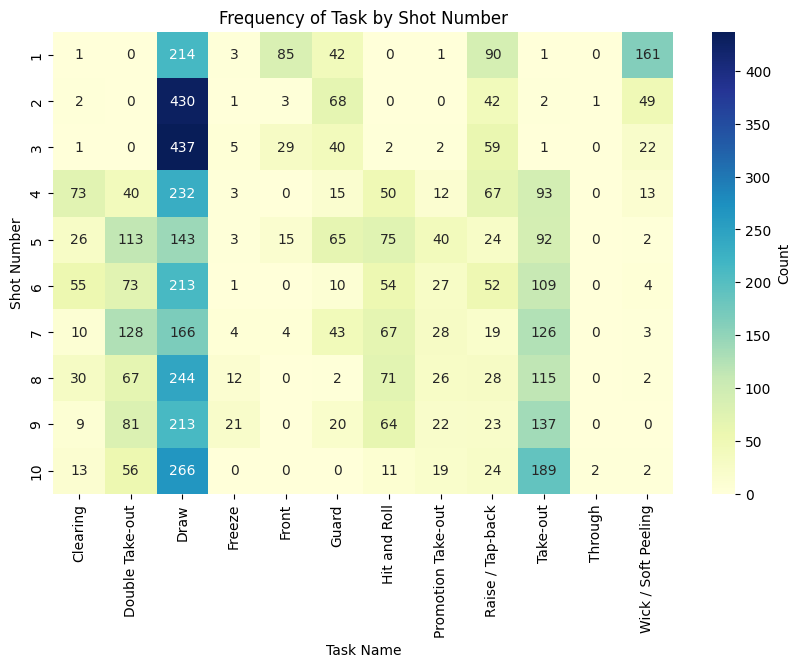

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

freq = pd.crosstab(powerplay_stones["ShotNum"], powerplay_stones["TaskName"])
freq = freq.sort_index().sort_index(axis=1)  # optional: order rows/cols

plt.figure(figsize=(10, 6))
sns.heatmap(
    freq,
    annot=True,        # show numbers
    fmt="d",           # integer format
    cmap="YlGnBu",     # color map
    cbar_kws={'label': 'Count'}
)
plt.title("Frequency of Task by Shot Number")
plt.xlabel("Task Name")
plt.ylabel("Shot Number")
plt.show()

The above visualization shows the frequency of each Task Type across different shot numbers.

**Takeaways**

* High Variability in opening move (for non-hammer team)
* Second and Third shot are nearly always draws
* Next significant shot is fourth shot (hammer team)
* Fifth overall shot is most variable (third non-hammer shot)
* Draws are much more common for the hammer team (forces non-hammer team to perform a take-out)

### **How should the non-hammer team start their end to reduce the chance of a big powerplay score?**

In [19]:
# Only include TaskNames that have at least 5 instances as the first shot
# Calculate the frequency of each TaskName
task_counts = first_shot['TaskName'].value_counts()
# Identify TaskNames with at least 5 instances
frequent_tasks = task_counts[task_counts >= 5].index
# Filter first_shot to include only these frequent TaskNames
first_shot = first_shot[first_shot['TaskName'].isin(frequent_tasks)]

first_shot.groupby('TaskName')['NonHammerScore'].agg(["count", "mean", "std", ("Steal Rate", lambda x: (x > 0).sum()/len(x)), ("Multi Point Loss Rate", lambda x: (x < -1).sum()/len(x)), ("3+ Point Loss Rate", lambda x: (x < -2).sum()/len(x))]).round(3)

,count,mean,std,Steal Rate,Multi Point Loss Rate,3+ Point Loss Rate
TaskName,,,,,,
Draw,214,-1.449,1.487,0.150,0.556,0.238
Front,85,-1.129,1.280,0.153,0.376,0.071
Guard,42,-1.548,1.087,0.071,0.476,0.190
Raise / Tap-back,90,-1.200,1.630,0.200,0.456,0.189
Wick / Soft Peeling,161,-1.329,1.657,0.186,0.497,0.230


If a non-hammer team is looking to reduce the number of points scored in the end, the team should start with a **Front**. With this method, the non-hammer team gives up multiple points just 37.6% of the time, and gives up 3+ points only 7.1% of the time.

### **How does starting stone location impact the Hammer's score distribution?**

At the beginning of a powerplay, the hammer team gets to choose where they place each stone. When examining the distribution of scores for the hammer team, this location decision does NOT make a significant difference in the hammer team’s results as depicted in the below visualization. A Hammer team choosing to start with their stone on the button or as a guard yielded similar results.

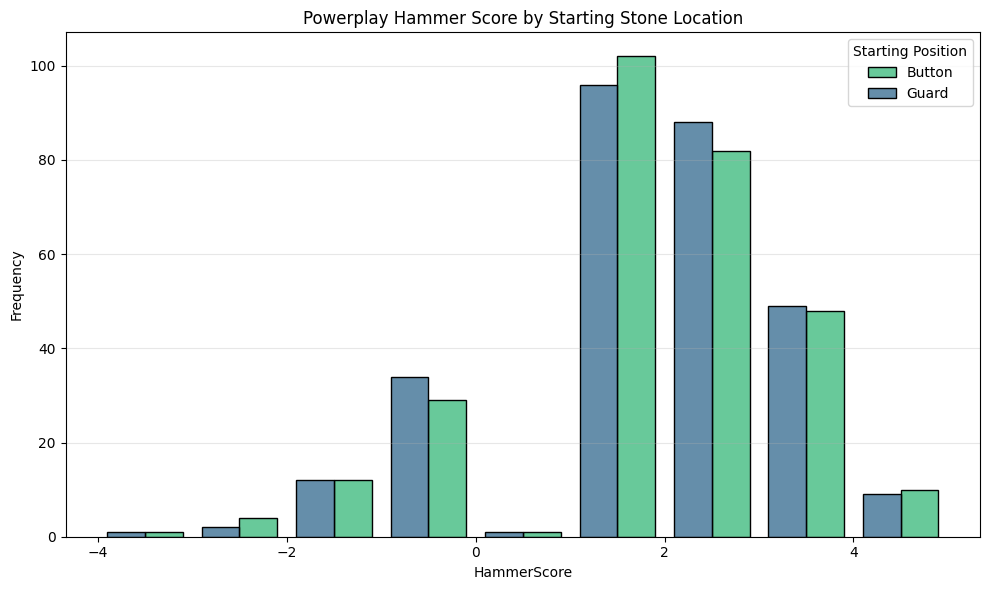

In [20]:
# Re-calculate HammerStoneStartingPosition for the current 'first_shot' DataFrame
first_shot.loc[:, 'HammerStoneStartingPosition'] = first_shot.apply(determineHammerStartingPosition, axis=1)

# remove rows where HammerStoneStartingPosition is unknown
first_shot = first_shot[first_shot['HammerStoneStartingPosition'] != 'Unknown']

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
sns.histplot(
    data=first_shot,
    x='HammerScore',
    hue='HammerStoneStartingPosition', # Use hue to differentiate starting positions
    multiple='dodge', # Arrange bars side-by-side for comparison
    shrink=0.8, # Adjust bar width
    binwidth=1, # Bin width of 1 point for hammer score
    palette='viridis' # Choose a color palette
)

plt.title('Powerplay Hammer Score by Starting Stone Location')
plt.xlabel('HammerScore')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Starting Position', labels=first_shot['HammerStoneStartingPosition'].unique())
plt.tight_layout()
plt.show()

Additionally, the mean for each starting position are both about 1.33 points per end, indicating no significant difference across nearly 600 powerplay rounds.

In [21]:
first_shot.groupby('HammerStoneStartingPosition')['HammerScore'].agg(["count", "mean", ("steal_rate", lambda x: (x < 0).sum()/len(x))]).round(3)

,count,mean,steal_rate
HammerStoneStartingPosition,,,
Button,292,1.336,0.168
Guard,289,1.329,0.159


### **How many stones should be in play for a big score end?**

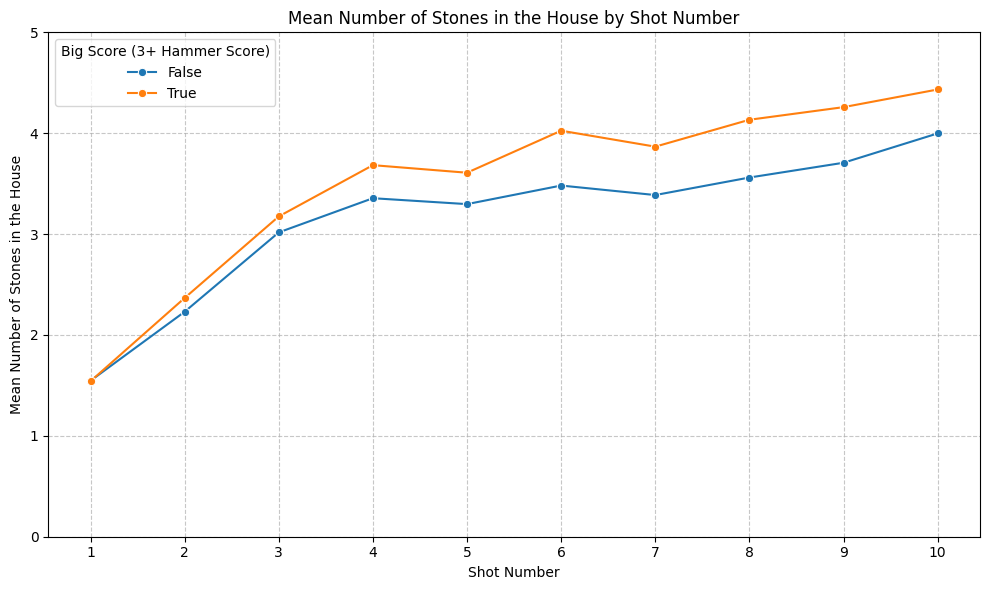

In [22]:
# Add Big Score as a HammerScore > 2 to house_stone_seq_df
house_stone_seq_df['Big Score'] = house_stone_seq_df['Hammer Score'].apply(lambda x: True if x > 2 else False)

# Retrieve the Grouped Data, which identified the mean house stones per shot
mean_stones_in_house = house_stone_seq_df.groupby(['Shot Number', 'Big Score'])['Number of House Stones'].agg("mean")

# Convert the Series to a DataFrame
plot_df = mean_stones_in_house.reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_df,
    x='Shot Number',
    y='Number of House Stones',
    hue='Big Score',
    marker='o'
)

plt.title('Mean Number of Stones in the House by Shot Number')
plt.xlabel('Shot Number')
plt.ylabel('Mean Number of Stones in the House')
plt.xticks(range(1, 11)) # Ensure all shot numbers are visible on x-axis

# Include Y range of 0, 5
plt.ylim(0, 5)

# Have Y Range from
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Big Score (3+ Hammer Score)')
plt.tight_layout()
plt.show()

Scoring three or more points during a power play requires more stones in the house. While the first three shots show similar patterns in stone accumulation between high-scoring and low-scoring ends, high-scoring ends show steeper increases in stones between shots 3-4 and 5-6 compared to low-scoring ends (Figure 10). This indicates that the hammer team should use the fourth and sixth shots to draw or find another way of adding stones into the house at these moments to increase the likelihood that they score big on the powerplay.  

Likewise, the non-hamer team’s best course of action to prevent this assault is to make it as difficult or risky as possible for the hammer team to get a stone on the house during the 4th and 6th shot.  Both high and low point scoring ends involve an increase in take outs during the 5th shot, slightly reducing the number of house stones on average, but hammer teams who score >2 points are much more likely to respond better the next play.


### **What early-end powerplay strategies are most likely to result in big scores for the hammer team?**

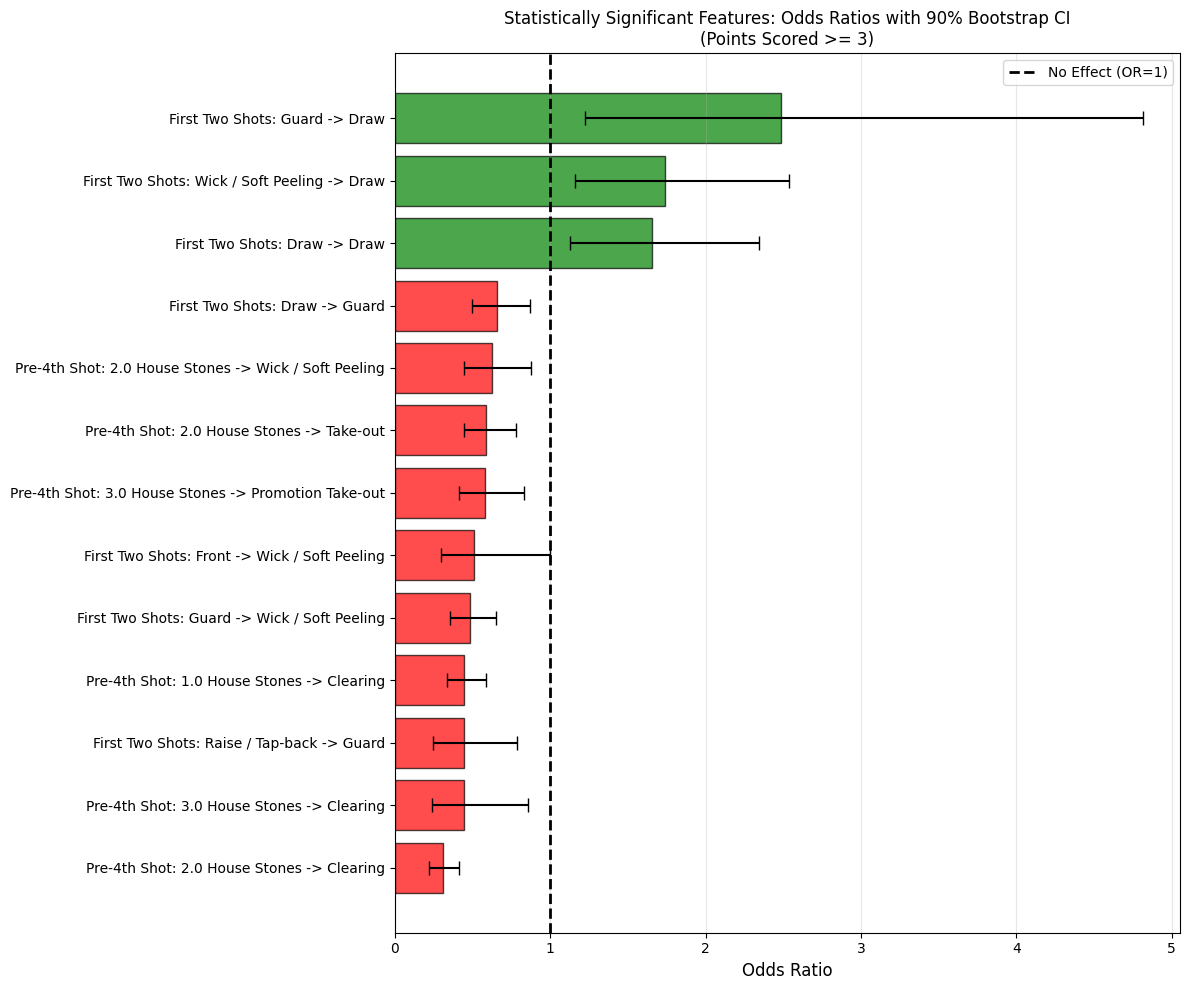

In [26]:
# Filter for statistically significant features (90% CI does not overlap 1)
significant_features = results_df[
    (results_df['OR_CI_Lower'] > 1) | (results_df['OR_CI_Upper'] < 1)
].copy()

# Separate into positive and negative odds ratios
positive_features = significant_features[significant_features['Odds_Ratio'] > 1].copy()
negative_features = significant_features[significant_features['Odds_Ratio'] < 1].copy()

# Create visualization showing BOTH positive and negative
combined_features = significant_features.sort_values(by='Odds_Ratio', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))

y_pos = np.arange(len(combined_features))
odds_ratios = combined_features['Odds_Ratio'].values
or_lower = combined_features['OR_CI_Lower'].values
or_upper = combined_features['OR_CI_Upper'].values

# Calculate error bar sizes
lower_err = odds_ratios - or_lower
upper_err = or_upper - odds_ratios

# Color code: green if OR > 1 (increases odds), red if OR < 1 (decreases odds)
colors = ['green' if x > 1 else 'red' for x in odds_ratios]

ax.barh(y_pos, odds_ratios, xerr=[lower_err, upper_err],
        color=colors, alpha=0.7, capsize=5, edgecolor='black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(combined_features['Feature'], fontsize=10)
ax.set_xlabel('Odds Ratio', fontsize=12)
#ax.set_title('Statistically Significant Features: Odds Ratios with 90% Bootstrap CI\n(Points Scored >= 3)\nGreen = Increases 3+ Score Odds | Red = Decreases 3+ Score Odds', fontsize=12)
ax.set_title('Statistically Significant Features: Odds Ratios with 90% Bootstrap CI\n(Points Scored >= 3)')
ax.axvline(x=1, color='black', linestyle='--', linewidth=2, label='No Effect (OR=1)')

ax.legend(fontsize=10)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

We then ran a logistic regression model to identify early powerplay strategic decisions for the hammer team that may indicate better or worse odds at getting a big scoring powerplay.

While the non-hammer team may choose to draw, soft peel, or throw a guard with their first throw, it is generally viable for the hammer team to draw in response. Following a guard, the hammer team is 2.5 times more likely on average to score 3 or more points if they **draw** on their second stone.

Additionally, for the 4th shot, the hammer team should avoid clearing or performing a take-out when trying for a big powerplay score. These shots remove stones in play, which is inadvisable for scoring big.